In [2]:
# %reload_ext autoreload
# %autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# TODO
Try minsSinceLEP - though this also gives away timing

# Load data

In [3]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [4]:
import stitch_pipeline_results
from importlib import reload
reload(stitch_pipeline_results)

df = stitch_pipeline_results.stitch_all_days_optimised(input_dir)

  0%|          | 0/121 [00:00<?, ?it/s]

C:\dev\play\brainwave-processor\stitch_pipeline_results.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return post_stitch(pd.concat(all_dfs), should_remove_days_per_questionnaire)
C:\dev\play\brainwave-processor\stitch_pipeline_results.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 190.5  190.   189.5 ... -425.  -425.5 -426. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[group.index, 'SSMinsUntilLongWake'] = (df.loc[first_long_wake_idx, 'Timestamp'] - df.loc[group.index, 'Timestamp']).dt.total_seconds() / 60


In [49]:
[col for col in df.columns if "lep" in col.lower()]

['minsSinceLEP']

# Prepare data

In [71]:
[col for col in df.columns if 'sleep' in col.lower()]

['15MinsBeforeSleep',
 '30MinsBeforeSleep',
 '60MinsBeforeSleep',
 'SleepHour1To2',
 'SleepHour3To4',
 'SleepHour5To6',
 'SleepHour7To8',
 'minsSinceAsleep',
 '15MinsBeforeReadyToSleep',
 '30MinsBeforeReadyToSleep',
 '60MinsBeforeReadyToSleep',
 'DuringReadyToSleep',
 'minsSinceReadyToSleep',
 'ProbablySleep',
 'SSPreReadyToSleep',
 'SSAfterSleep',
 'SSDuringReadyToSleep',
 'SSDuringSleep',
 'SSWakeDuringSleep']

In [72]:
import sys
from importlib import reload
import models.util.epoch_level_features
reload(models.util.epoch_level_features)
import time_to_sleep_model
reload(time_to_sleep_model)

models_and_data = time_to_sleep_model.create_and_add_all(df, False)

from sklearn.model_selection import train_test_split

def split(modelAndData: time_to_sleep_model.ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.1, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

for md in models_and_data:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

NaN indices: [] (0 total of 95889)
Infinity indices: []
Too large indices: []
CleanTargetCol (95889, 352) to (95889, 352)
Condition (95889, 352) to (9928, 352), first index 60
FeaturesHandler (9928, 352) to (9928, 352) Had 352 features, after filtering have 141 features, first index 60
RequireNonEmptyRows (9928, 141) to (9928, 141), first index 60
DropBadRows (9928, 141) to (9928, 141), first index 60
NaN indices: [] (0 total of 95889)
Infinity indices: []
Too large indices: []
CleanTargetCol (95889, 352) to (95889, 352)
Condition (95889, 352) to (9857, 352), first index 51
FeaturesHandler (9857, 352) to (9857, 352) Had 352 features, after filtering have 141 features, first index 51
RequireNonEmptyRows (9857, 141) to (9857, 141), first index 51
DropBadRows (9857, 141) to (9857, 141), first index 51
NaN indices: [] (0 total of 95889)
Infinity indices: []
Too large indices: []
CleanTargetCol (95889, 352) to (95889, 352)
Condition (95889, 352) to (18104, 352), first index 0
FeaturesHandle

# Train models

In [74]:
import models.util.importances as importances
reload(importances)

import models.util.rfe_training as training
reload(training)
import copy

import memory

memory.garbage_collect(print)

train_list = []
# train_list.append({"type": "XGBoost+HSTreeClassifierCV", "requireRemovedNan": True})
# train_list.append({"type": "ExplainableBoostingClassifier"})
# train_list.append({"type": "ExplainableBoostingRegressor"})
# train_list.append({"type": "FIGSRegressor", "rfe": False, "requireRemovedNan": True})
train_list.append({"type": "XGBoost", "rfe": True, "supportsFeatureWeights": True})



for md in models_and_data:
    models = []
    for tl in train_list:
        if tl.get('requireRemovedNan', False) and not md.removed_nan:
            continue

        tl_copy = copy.deepcopy(tl)
        if (tl['type'] == 'XGBoost'):
            tl_copy['type'] = 'XGBoostClassifier' if md.is_classifier else 'XGBoostRegressor'
        if (tl['type'] == 'XGBoost+HSTreeClassifierCV'):
            tl_copy['type'] = 'XGBoostClassifier+HSTreeClassifierCV' if md.is_classifier else 'XGBoostRegressor+HSTreeRegressor'

        rfe = tl.get('rfe', False)
        models.extend(training.train_rfe(training.get_model, tl_copy, md.name, md.X_train, md.y_train, md.X_val, md.y_val, rfe))
    md.models = models

import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)
pd.set_option('display.max_columns', None)

display(evaluation.evaluate_regression_models(models_and_data))
display(evaluation.evaluate_classification_models(models_and_data))


Memory Usage: 1036.07 MB GC to 1022.68 MB
Training XGBoostRegressor model for minsSinceAsleepAllEeg1HrBefore with 140 features... RMSE train: 0.8568680207744207 RMSE val: 5.8511372281968725
Training XGBoostRegressor model for minsSinceAsleepAllEeg1HrBefore with 70 features... RMSE train: 0.8566202682391656 RMSE val: 5.236840962880434
Training XGBoostRegressor model for minsSinceAsleepAllEeg1HrBefore with 35 features... RMSE train: 0.961030079207518 RMSE val: 5.028852625751957
Training XGBoostRegressor model for minsSinceAsleepAllEeg1HrBefore with 17 features... RMSE train: 1.3711986671862653 RMSE val: 5.175461453006351
Training XGBoostRegressor model for minsSinceAsleepAllEeg1HrBefore with 8 features... RMSE train: 1.8811631835460718 RMSE val: 5.833926665031316
Training XGBoostRegressor model for minsSinceAsleepAllEeg1HrBefore with 4 features... RMSE train: 5.056173378660916 RMSE val: 11.320131564751362
Training XGBoostRegressor model for minsSinceReadyToSleepAllEeg1HrBefore with 140 f

,MAE_Train,MAE_Val,RMSE_Train,RMSE_Val,Rows_Train,Model,n_features,source,isClassifier
0,0.606349,3.663194,0.856868,5.851137,8935,minsSinceAsleepAllEeg1HrBefore,140,XGBoostRegressor,False
1,0.608772,3.286222,0.856620,5.236841,8935,minsSinceAsleepAllEeg1HrBefore,70,XGBoostRegressor,False
2,0.679661,3.149304,0.961030,5.028853,8935,minsSinceAsleepAllEeg1HrBefore,35,XGBoostRegressor,False
3,0.920729,3.184027,1.371199,5.175461,8935,minsSinceAsleepAllEeg1HrBefore,17,XGBoostRegressor,False
4,1.271058,3.607390,1.881163,5.833927,8935,minsSinceAsleepAllEeg1HrBefore,8,XGBoostRegressor,False
5,3.645508,8.085061,5.056173,11.320132,8935,minsSinceAsleepAllEeg1HrBefore,4,XGBoostRegressor,False
6,0.605764,3.854026,0.854731,5.435136,8871,minsSinceReadyToSleepAllEeg1HrBefore,140,XGBoostRegressor,False
7,0.594273,3.433835,0.846069,4.978168,8871,minsSinceReadyToSleepAllEeg1HrBefore,70,XGBoostRegressor,False
8,0.744789,3.165297,1.068300,4.529935,8871,minsSinceReadyToSleepAllEeg1HrBefore,35,XGBoostRegressor,False
9,0.912695,3.378641,1.347338,5.089706,8871,minsSinceReadyToSleepAllEeg1HrBefore,17,XGBoostRegressor,False


C:\dev\play\brainwave-processor\models\util\evaluation.py:247: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



""


In [58]:
bm = models_and_data[0].models[0]

# Evaluate the model

Evaluation for model:  minsSinceReadyToSleepAllEeg1HrBeforeJustEeg
minsSinceReadyToSleepAllEeg1HrBeforeJustEeg Training Set Evaluation:
MAE: 1.4303025555823585, MSE: 4.062729535227164, RMSE: 2.0156213769523195
minsSinceReadyToSleepAllEeg1HrBeforeJustEeg Validation Set Evaluation:
MAE: 6.233656091845235, MSE: 70.93201653636537, RMSE: 8.422114730657935


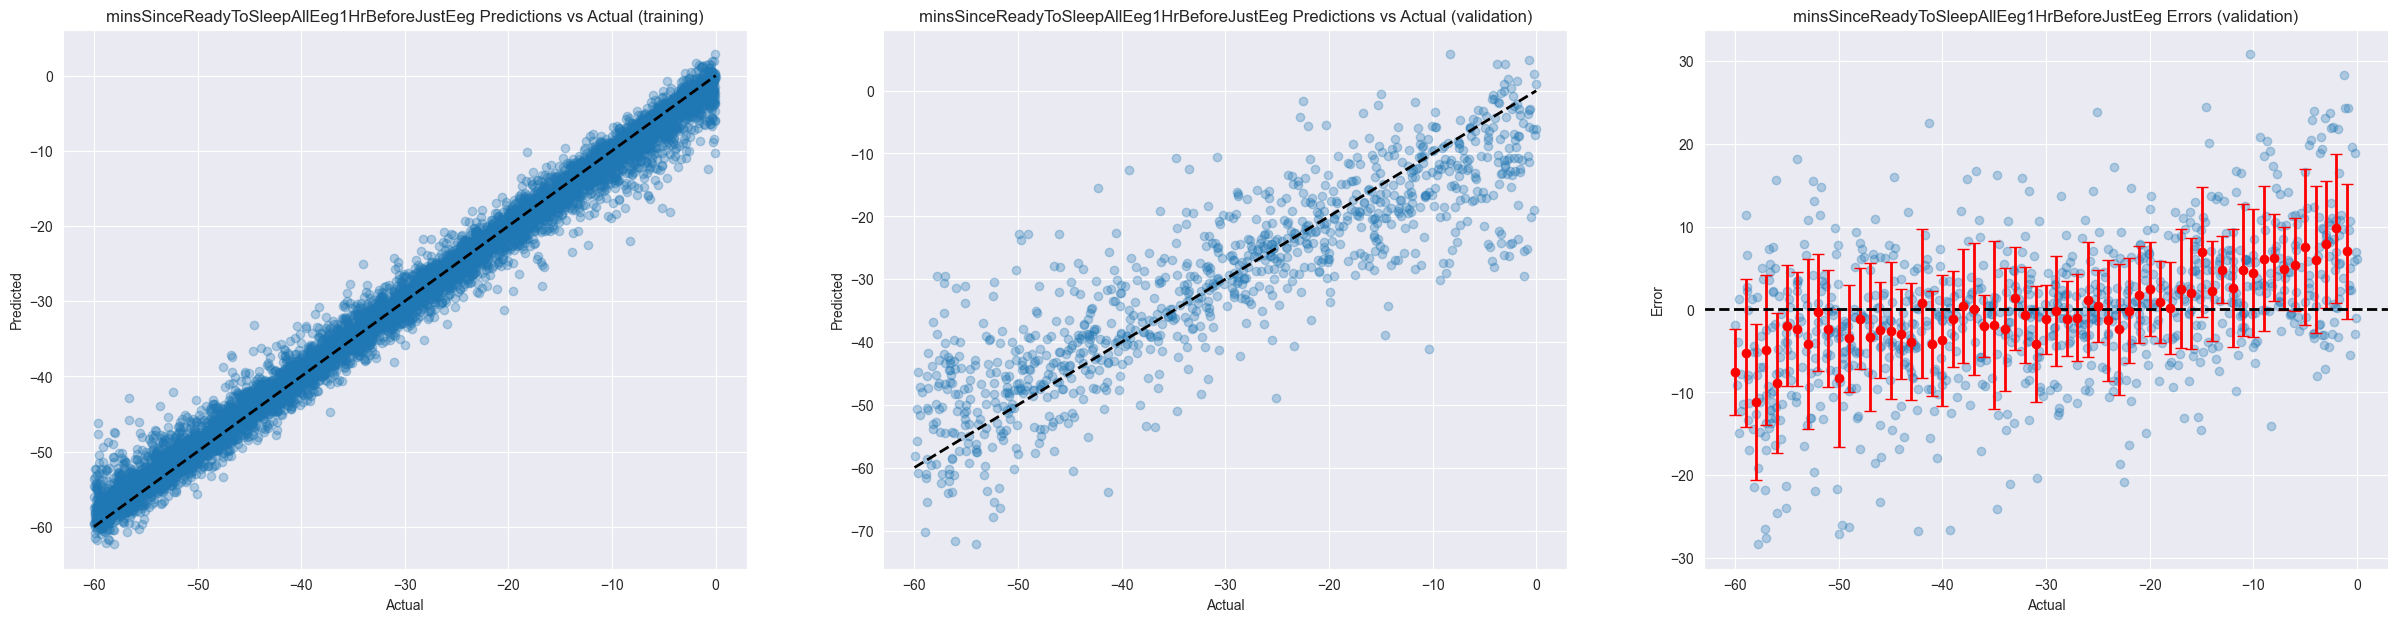

In [69]:
import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)

evaluation.evaluate_model(bm.model, bm.name, bm.X_train, bm.y_train, bm.X_val, bm.y_val, bm.is_classifier)


 # Save model


In [43]:
%%capture
filenames = []

try:
    os.mkdir("models")
except:
    pass

for md in models_and_data:
    for ms in md.models:
        model_filename = f"models/{'cls' if md.is_classifier else 'reg'}_{md.name}_rfe{len(ms.X_train.columns)}_xgboost_model.cbm"
        log(f"Saving model {md} to {model_filename}")
        ms.model.save_model(model_filename)
        filenames.append(model_filename)


In [44]:
for fn in filenames:
    print(f"\"{fn}\",")

"models/reg_minsSinceReadyToSleepEEGOnly_rfe135_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleepEEGOnly_rfe67_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleepEEGOnly_rfe33_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleepEEGOnly_rfe16_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleepEEGOnly_rfe12_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleepEEGOnly_rfe8_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleepEEGOnly_rfe4_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_rfe131_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_rfe65_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_rfe32_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_rfe16_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_rfe12_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_rfe8_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_rfe4_xgboost_model.cbm",


# Most useful features

In [66]:
from interpret import show
show(bm.model.explain_global())


<!-- http://127.0.0.1:7001/2262760372352/ -->

In [50]:
%%capture

import shap
import xgboost as xgb


explainer = shap.Explainer(bm.model)
shap_values = explainer(bm.X_train)

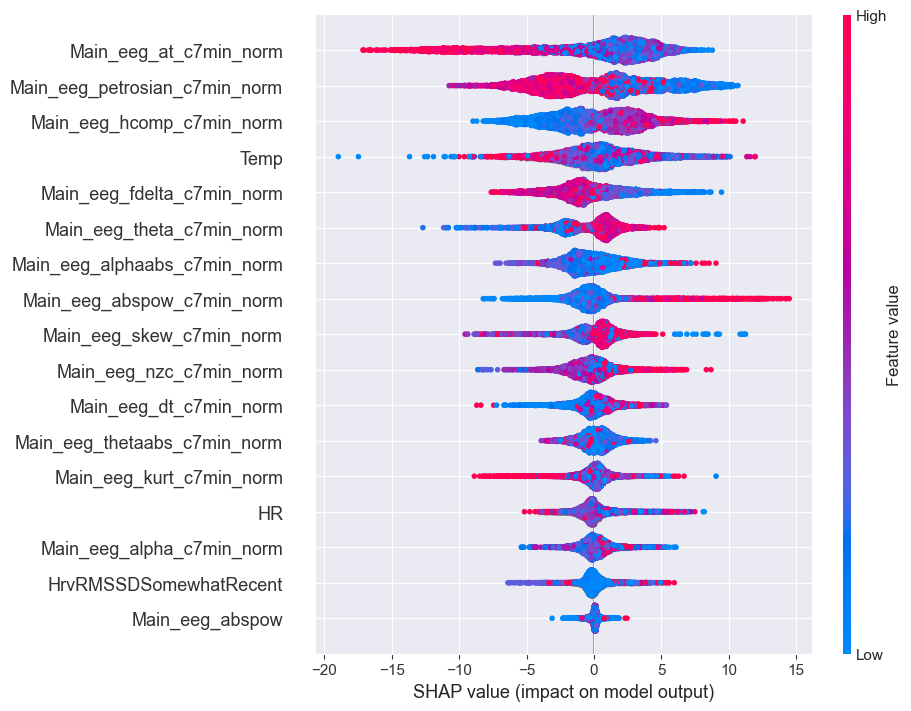

In [51]:
shap.plots.beeswarm(shap_values, max_display=20)


In [21]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Get the indices of the top 16 features
top_features_indices = np.argsort(mean_abs_shap_values)[-16:][::-1]

# Get the names of the top 16 features
top_features = [shap_values.feature_names[i] for i in top_features_indices]

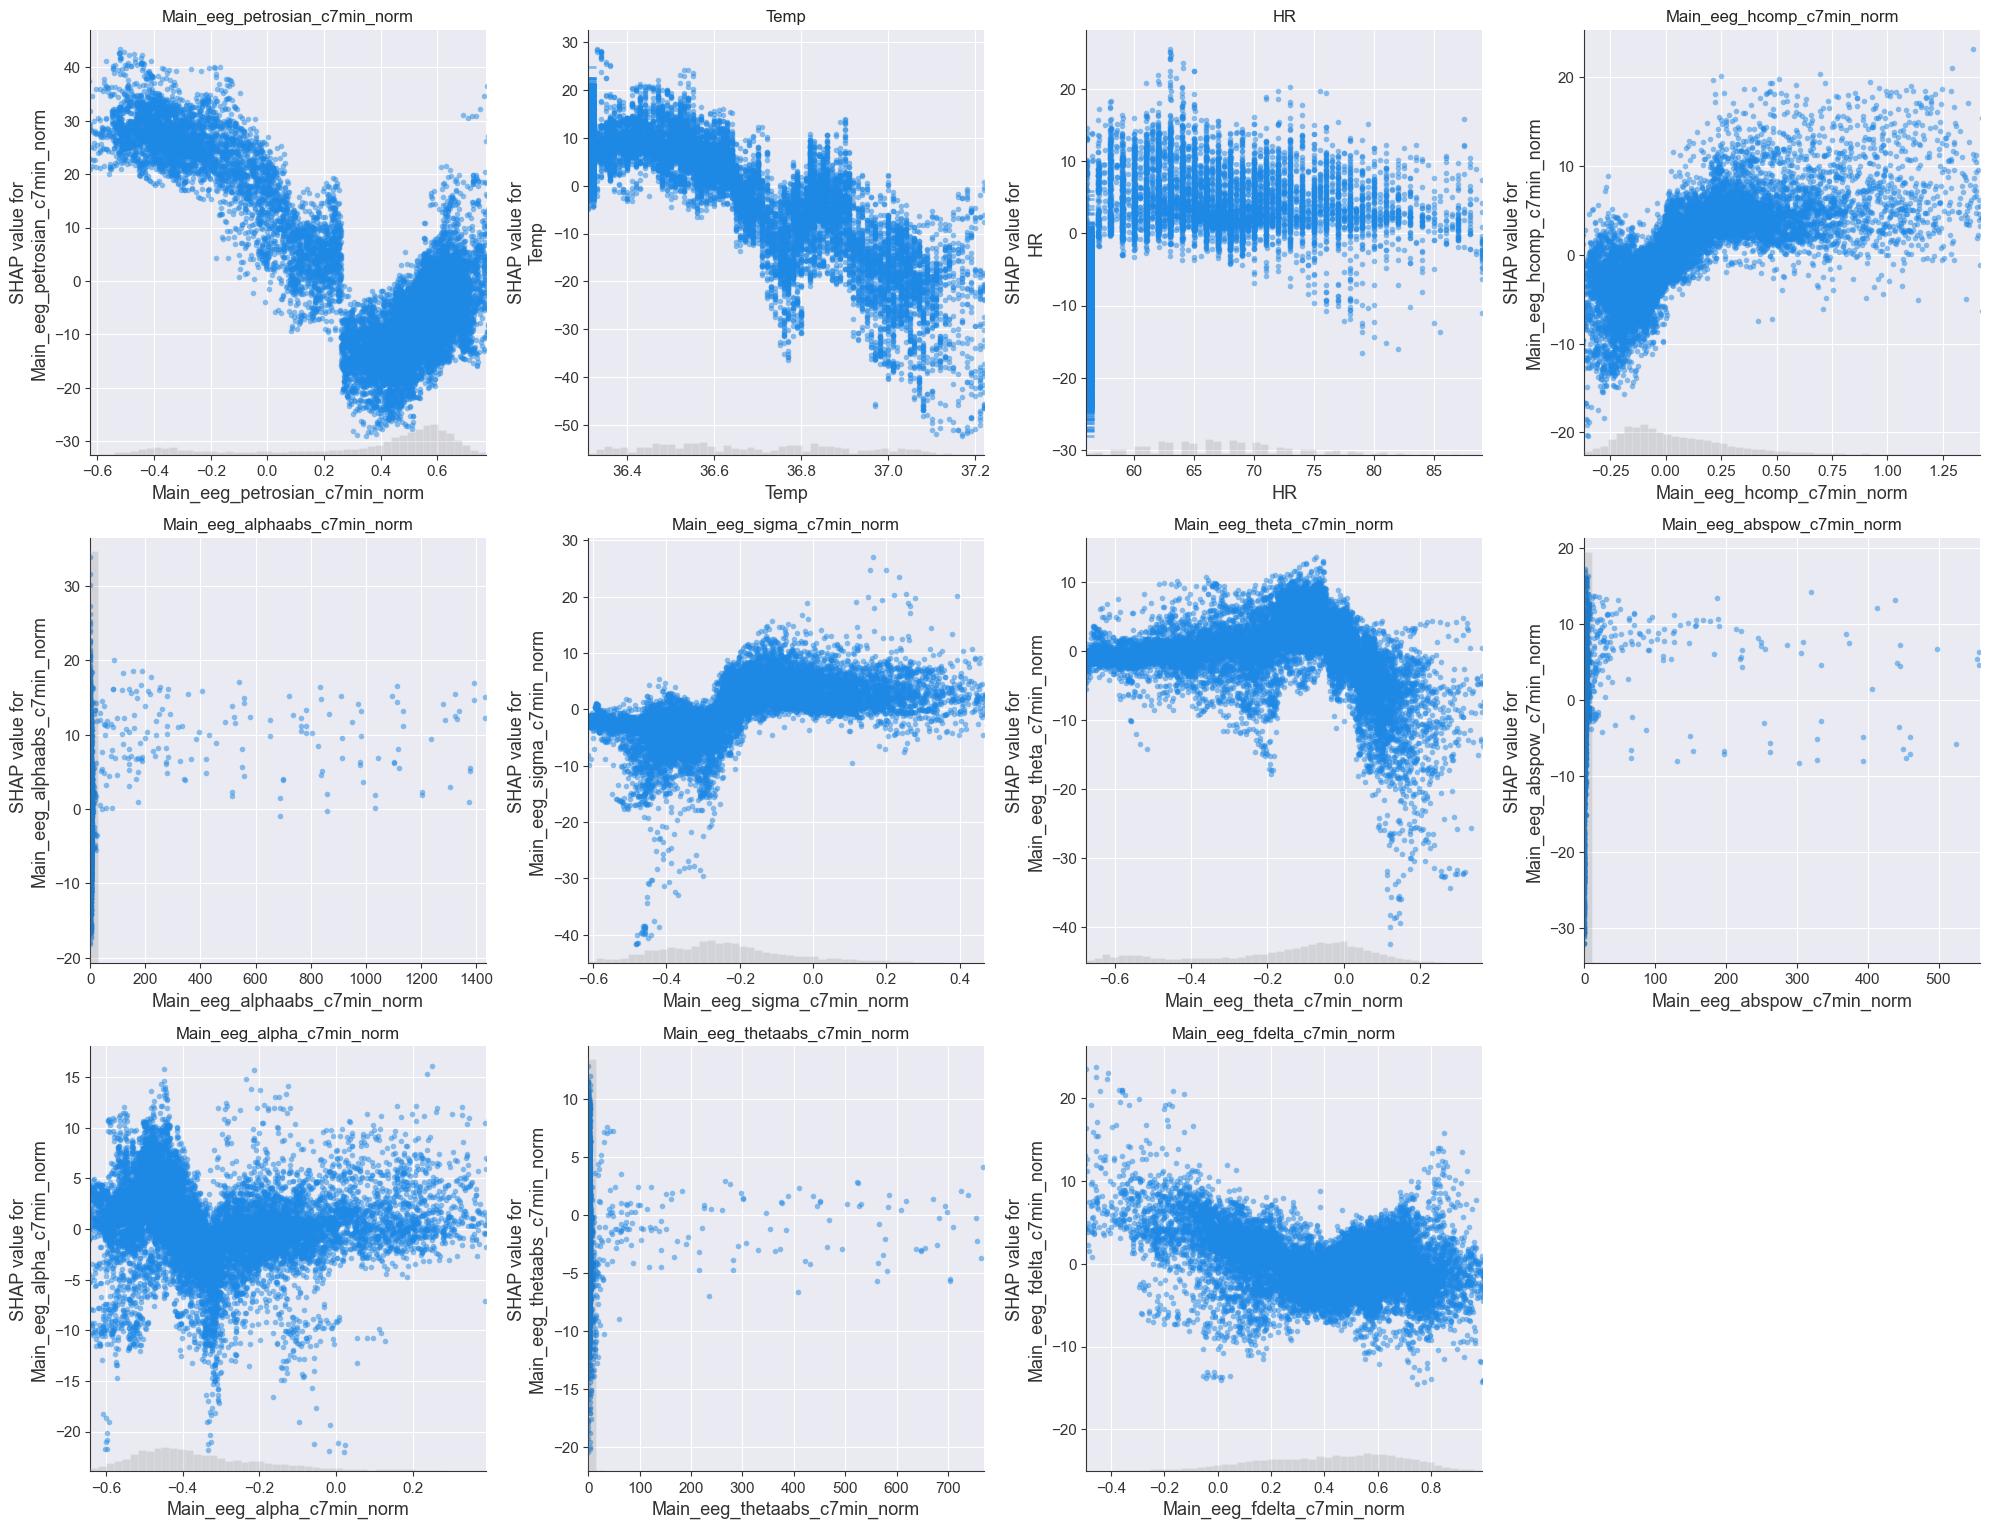

In [22]:
import matplotlib.pyplot as plt
import shap

# Create a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(top_features):
    shap.plots.scatter(shap_values[:, feature], ax=axes[i], show=False, xmin='percentile(1)', xmax='percentile(99)', alpha=0.5)  # Avoid triggering plt.show()
    axes[i].set_title(feature)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [29]:
shap.dependence_plot(0, shap_values, modelsAndData[0].X_train)

TypeError: loop of ufunc does not support argument 0 of type Explanation which has no callable conjugate method

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

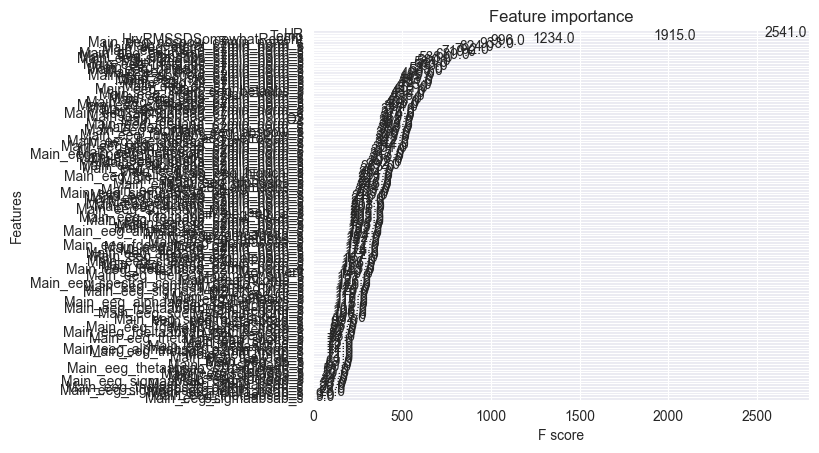

In [31]:
xgb.plot_importance(bm.model)

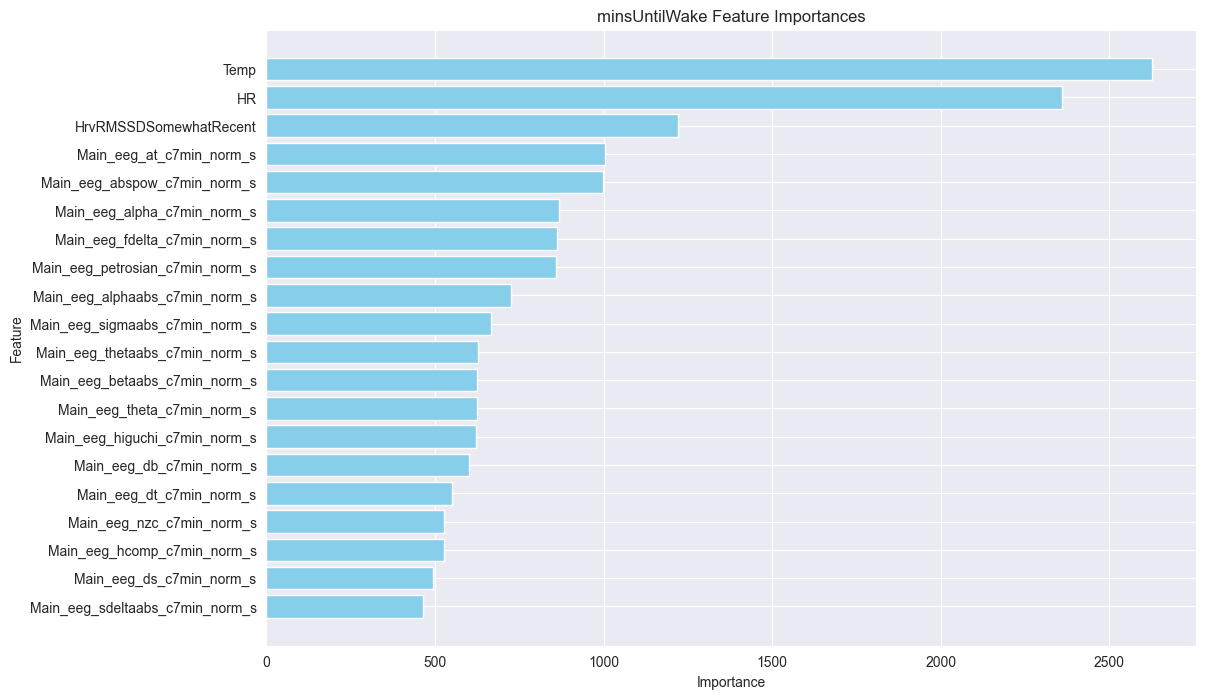

In [14]:
import models.util.importances as importances
from importlib import reload
reload(importances)
    
for md in modelsAndData:
    imp = importances.xgboost_importances(md)[0:20]
    importances.plot_importances(imp, md.name)

In [15]:
Ypetest_md = modelsAndData[0]

In [16]:
import seaborn as sns
sns.scatterplot(x='Main_eeg_perment_s', y=test_md.target_col, data=test_md.prepared_df)


NameError: name 'test_md' is not defined

In [75]:
test_md.prepared_df

,Confidence_x,F8-M1_Confidence_x,T4-M1_Confidence_x,O2-M1_Confidence_x,StageInt_x,Main_eeg_abspow_s,Main_eeg_abspow_c7min_norm_s,Main_eeg_abspow_p2min_norm_s,Main_eeg_alpha_s,Main_eeg_alpha_c7min_norm_s,...,Fpz-M1_Confidence_x,F4-M1_Confidence_x,Fpz-M1_Confidence_y,F4-M1_Confidence_y,SettlingEventMatchedIdx,SettlingManualScore,SettlingV4ManualScore,TiredVsAlertManualScore,SettlingV4ScorePrediction,WillWakeWithin60Mins
2,0.999987,0.999951,0.999987,0.999412,0,0.673643,0.631520,1.210844,0.074071,-0.139941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,0.999875,0.999564,0.999875,0.997296,0,0.740908,0.620911,1.136667,0.091764,-0.137007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,0.999843,0.998763,0.999843,0.996956,0,0.417889,0.609999,0.669285,0.161176,-0.133391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5,0.999532,0.998831,0.999532,0.997687,0,0.577379,0.604815,0.731069,0.068022,-0.130382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,0.999465,0.998943,0.999465,0.987641,0,0.811312,0.654045,0.744720,0.098874,-0.120942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,0.999282,NaN,NaN,NaN,0,0.279018,1.278017,2.111404,0.099304,-0.030497,...,0.999282,NaN,0.999282,NaN,NaN,NaN,NaN,NaN,1.0,False
1145,0.997849,NaN,NaN,NaN,0,1.149445,1.162454,1.264398,-0.015355,-0.004882,...,0.997849,NaN,0.997849,NaN,NaN,NaN,NaN,NaN,1.0,False
1146,0.997343,NaN,NaN,NaN,0,0.348046,1.017307,0.871481,0.121749,0.027155,...,0.997343,NaN,0.997343,NaN,NaN,NaN,NaN,NaN,1.0,False
1147,0.998733,NaN,NaN,NaN,0,0.595378,0.870215,0.761752,0.069582,0.060004,...,0.998733,NaN,0.998733,NaN,NaN,NaN,NaN,NaN,1.0,False


<Axes: xlabel='TimeToReadyToSleepMins', ylabel='Main_eeg_perm_s'>

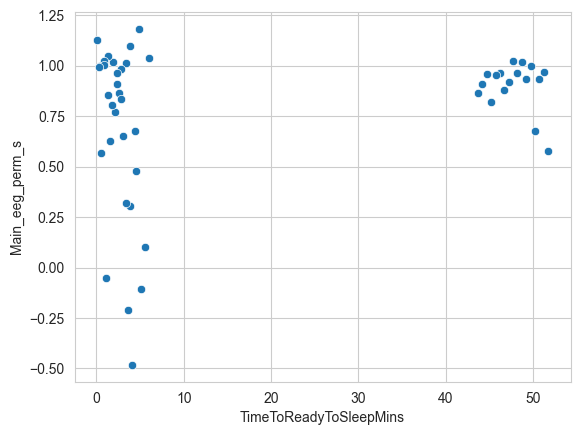

In [160]:
day1 =  test_md.prepared_df[0:48]
sns.scatterplot(y='Main_eeg_perm_s', x=target_cols[1], data=day1)


In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_avg_feature(df, col_name, ax, max_time_to_ready_to_sleep_mins=50):
    # Create a new column with the integer version of the x values
    df2 = df.copy()
    df2['TimeToReadyToSleepMins_int'] = df2['TimeToReadyToSleepMins'].astype(int)
    df2 = df2[df2['TimeToReadyToSleepMins_int'] <= max_time_to_ready_to_sleep_mins]

    # Group by the integer version of x and calculate the mean for each group
    grouped = df2.groupby('TimeToReadyToSleepMins_int').mean().reset_index()

    # Plot the average value for each integer version of x with a linear regression line
    sns.regplot(x='TimeToReadyToSleepMins_int', y=col_name, data=grouped, ax=ax, scatter_kws={'s': 10})
    ax.set_title(col_name)

# Calculate Pearson correlation for each column
correlations = test_md.prepared_df.corr()['TimeToReadyToSleepMins'].drop('TimeToReadyToSleepMins').sort_values(ascending=False)

# Get the list of columns to plot, ordered by Pearson correlation
columns_to_plot = correlations.index

# Create a figure and axes for the subplots
num_cols = 4
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns_to_plot):
    plot_avg_feature(test_md.prepared_df, col, axes[i])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

KeyError: 'TimeToReadyToSleepMins'

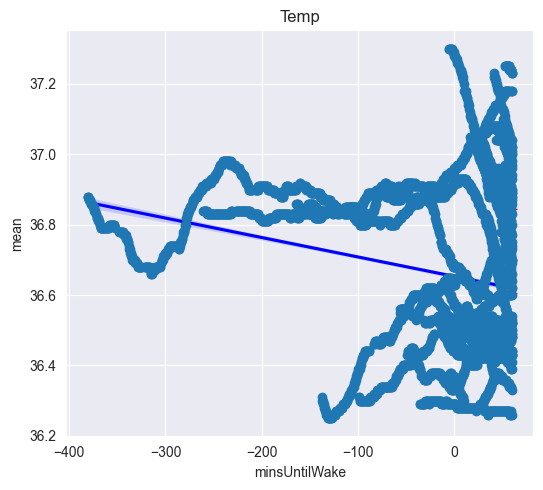

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_avg_feature(df, col_name, ax, max_time=60):
    # Create a new column with the integer version of the x values
    df2 = df.copy()
    df2 = df2[df2['minsUntilWake'] <= max_time]
    grouped = df2.groupby('minsUntilWake').agg({col_name: ['mean', 'std']}).reset_index()
    grouped.columns = ['minsUntilWake', 'mean', 'std']

    # Plot the average value for each integer version of x with error bars
    ax.errorbar(grouped['minsUntilWake'], grouped['mean'], yerr=grouped['std'], fmt='o', ecolor='r', capsize=5)
    sns.regplot(x='minsUntilWake', y='mean', data=grouped, ax=ax, scatter=False, line_kws={'color': 'blue'})
    ax.set_title(col_name)

# Calculate Pearson correlation for each column
# correlations = test_md.prepared_df.corr()['TimeToReadyToSleepMins'].drop('TimeToReadyToSleepMins').sort_values(ascending=False)

# Get the list of columns to plot, ordered by Pearson correlation
# columns_to_plot = correlations.index
columns_to_plot = ['Temp']

# Create a figure and axes for the subplots
num_cols = 4
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns_to_plot):
    plot_avg_feature(merged, col, axes[i])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

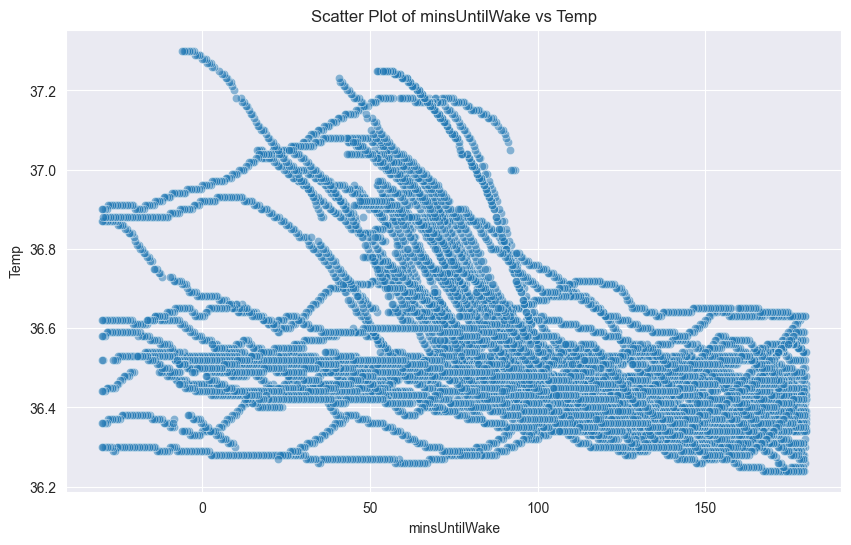

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for minsUntilWake <= 60
filtered_df = merged[(merged['minsUntilWake'] <= 180) & (merged['minsUntilWake'] >= -30)]

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='minsUntilWake', y='Temp', data=filtered_df, alpha=0.5)
plt.title('Scatter Plot of minsUntilWake vs Temp')
plt.xlabel('minsUntilWake')
plt.ylabel('Temp')
plt.show()

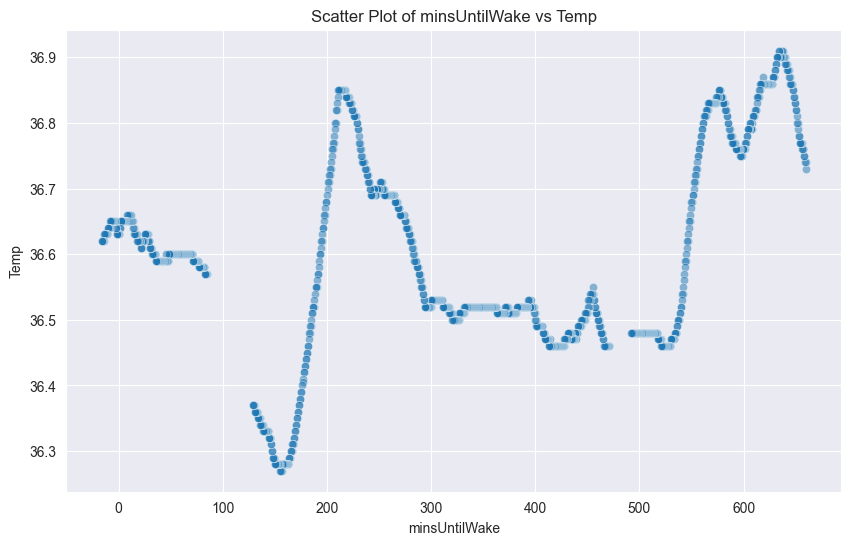

In [101]:
df = merged[merged['dayAndNightOf'] == '2024-12-05']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='minsUntilWake', y='Temp', data=df, alpha=0.5)
plt.title('Scatter Plot of minsUntilWake vs Temp')
plt.xlabel('minsUntilWake')
plt.ylabel('Temp')
plt.show()
